In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import numpy as np
from pathlib import Path
from random import randint
import pandas as pd

In [3]:
from fastai import *
from fastai.vision import *

### Dataset

[Amazon](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)


In [47]:
planet = untar_data(URLs.PLANET_TINY)

In [6]:
pd.read_csv(planet/'labels.csv').head()

,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


In [5]:
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [7]:
data = (ImageList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        .split_by_rand_pct()
        .label_from_df(cols='tags', label_delim=' ')
        .transform(planet_tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

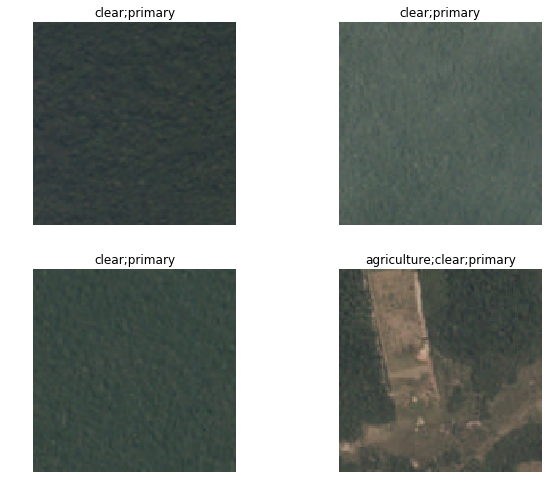

In [8]:
data.show_batch(rows=2, figsize=(9,7))

In [11]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [41]:
def create_head(nf:int, nc:int, ps:Floats=0.5, pool=None):
    layers = [AdaptiveConcatPool2d() if pool is None else pool, Flatten()]

    layers += bn_drop_lin(nf, nf // 2, True, ps, nn.ReLU(inplace=True))
    layers += bn_drop_lin(nf // 2, nc, True, ps)
    return nn.Sequential(*layers)
head = create_head(1024, data.c)

In [34]:
# CM
head = create_head(1024, data.c)

In [43]:
class LSEPool(nn.Module):
    """
    Learnable LSE pooling with a shared parameter
    """

    def __init__(self, r):
        super(LSEPool, self).__init__()
        self.r = nn.Parameter(torch.ones(1) * r)

    def forward(self, x):
        s = (x.size(2) * x.size(3))
        x_max = F.adaptive_max_pool2d(x, 1)
        exp = torch.exp(self.r * (x - x_max))
        sumexp = 1 / s * torch.sum(exp, dim=(2, 3))
        sumexp = sumexp.view(sumexp.size(0), -1, 1, 1)
        logsumexp = x_max + 1 / self.r * torch.log(sumexp)
        return logsumexp

head = create_head(512, data.c, pool=LSEPool(0.5))

In [44]:
learn = cnn_learner(data, models.resnet18, metrics=[acc_02, f_score], callback_fns=[ShowGraph], custom_head=head) #, custom_head=head

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


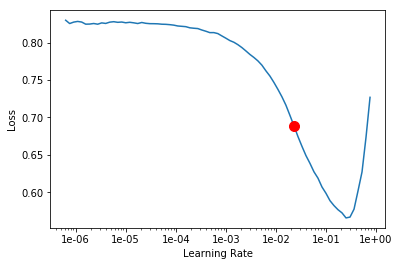

In [13]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.826056,0.681719,0.196429,0.531906,00:00
1,0.807534,0.660197,0.194643,0.528675,00:00
2,0.785299,0.633115,0.194643,0.528675,00:00
3,0.757850,0.584873,0.225000,0.537993,00:00
4,0.725662,0.529675,0.248214,0.545578,00:00
5,0.692031,0.479357,0.273214,0.548529,00:00
6,0.657570,0.437612,0.319643,0.558145,00:00
7,0.626340,0.401276,0.378571,0.580332,00:00
8,0.595059,0.378478,0.405357,0.591495,00:00
9,0.569441,0.369203,0.407143,0.596476,00:00


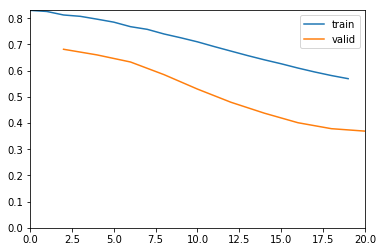

In [45]:
learn.fit_one_cycle(10,1e-2)

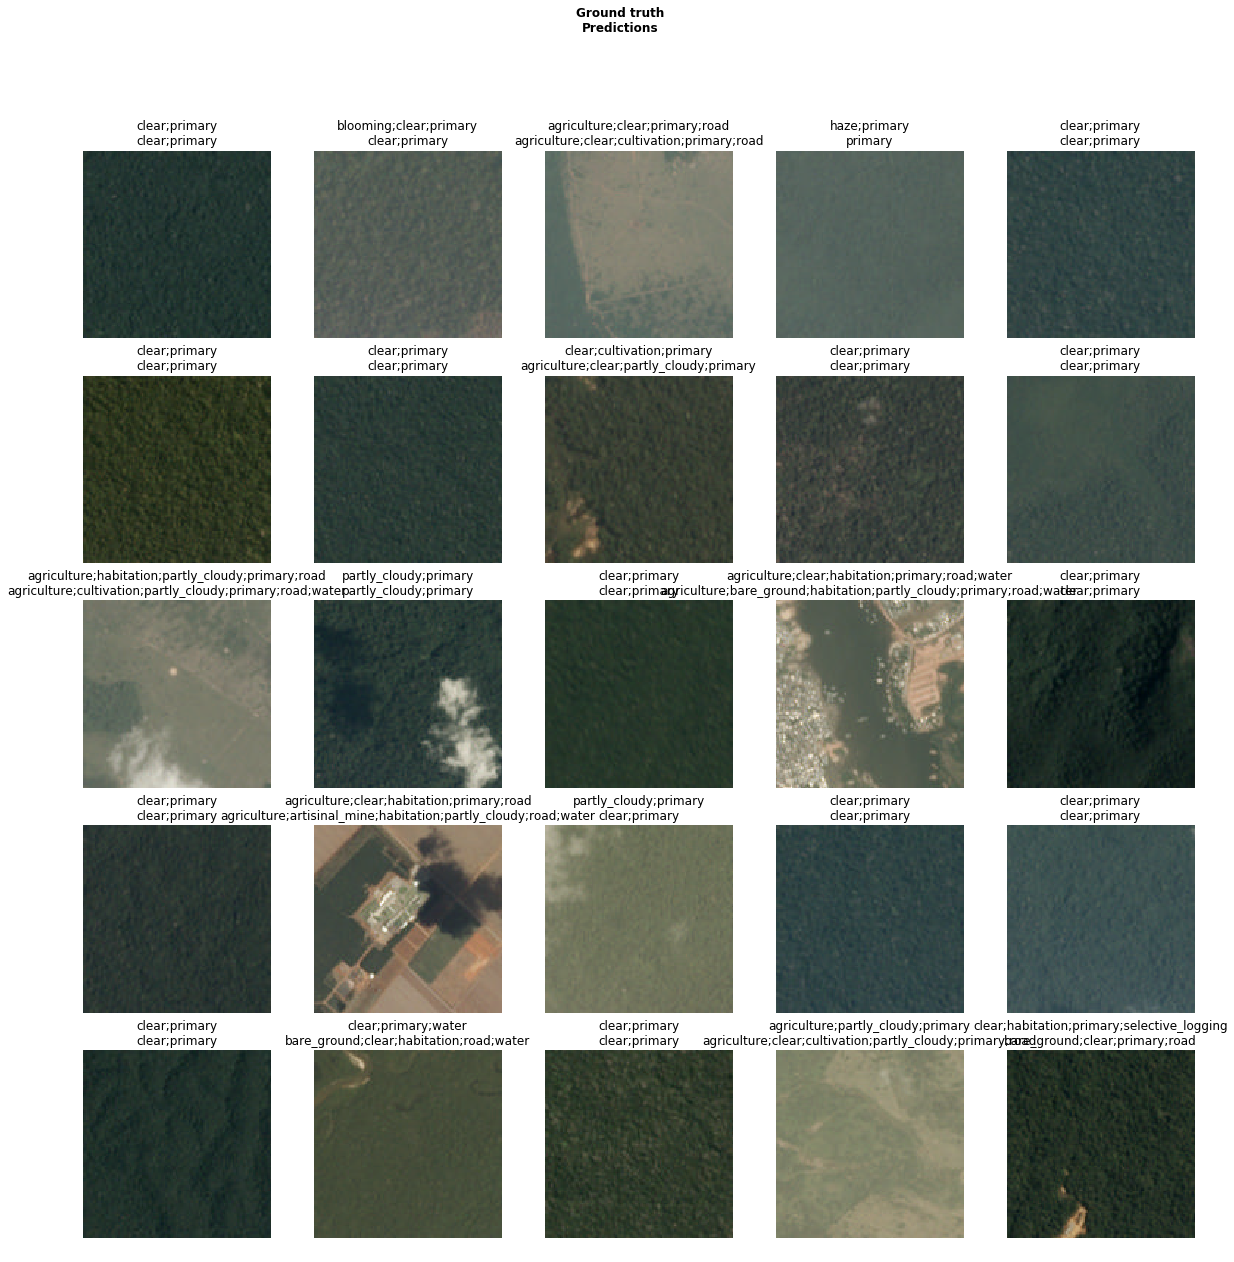

In [15]:
learn.show_results()